# **NAND gate layout generation with laygo2**

spdx-license-identifier: bsd-3-clause

Generate a NAND gate layout with [laygo2](https://laygo2.github.io)

## Install Dependencies

In [ ]:
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  !python -m pip install condacolab
  import condacolab
  condacolab.install()


In [ ]:
%%writefile environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  #- open_pdks.sky130a
  # - magic
  # - gdstk
  - cairosvg
  # - pyspice
  #- pip
  - pip:
    - laygo2
    - gdspy
    - pyyaml

In [ ]:
!mamba env update -n base -f environment.yml
# Load test technology (laygo2_tech_test).
!git clone https://github.com/niftylab/laygo2.git
!ln -s ./laygo2/laygo2_tech_quick_start .

In [ ]:
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  import condacolab
  CONDA_PREFIX = condacolab.PREFIX

##Import packages and set parameter values

In [ ]:
import numpy as np
import pprint
import laygo2
import laygo2.interface
# should be 'import laygo2_tech as tech' for actual use.
import laygo2_tech_quick_start as tech  

# Parameter definitions ##############
# Templates
tpmos_name = 'pmos'
tnmos_name = 'nmos'
# Grids
pg_name = 'placement_cmos'
r12_name = 'routing_12_cmos'
r23_name = 'routing_23_cmos'
# Design hierarchy
libname = 'laygo2_test'
cellname = 'nand2'
# Design parameters
nf_a = 3
nf_b = 4
# End of parameter definitions #######

## Load templates and grids

In [ ]:
# Generation start ###################
# 1. Load templates and grids.
print("Load templates")
templates = tech.load_templates()
tpmos, tnmos = templates[tpmos_name], templates[tnmos_name]
print(templates[tpmos_name], templates[tnmos_name], sep="\n")

print("Load grids")
grids = tech.load_grids(templates=templates)
pg, r12, r23 = grids[pg_name], grids[r12_name], grids[r23_name]
print(grids[pg_name], grids[r12_name], grids[r23_name], sep="\n")

Load templates
<laygo2.object.template.UserDefinedTemplate object at 0x7fceefe1fe50> name: pmos, class: UserDefinedTemplate, 
<laygo2.object.template.UserDefinedTemplate object at 0x7fceefe1f850> name: nmos, class: UserDefinedTemplate, 
Load grids
<laygo2.object.grid.PlacementGrid object at 0x7fceefe267d0> name: placement_cmos, class: PlacementGrid, scope: [[0, 0], [30, 100]], elements: [array([0]), array([0])]
<laygo2.object.grid.RoutingGrid object at 0x7fceefe26d10> name: routing_12_cmos, class: RoutingGrid, scope: [[0, 0], [30, 200]], elements: [array([0]), array([ 10,  40,  60,  90, 110, 140, 160, 190])]
<laygo2.object.grid.RoutingGrid object at 0x7fceefe2a6d0> name: routing_23_cmos, class: RoutingGrid, scope: [[0, 0], [30, 200]], elements: [array([0]), array([ 10,  40,  60,  90, 110, 140, 160, 190])]


## Create a design hierarchy

In [ ]:
# 2. Create a design hierarchy.
lib = laygo2.object.database.Library(name=libname)
dsn = laygo2.object.database.Design(name=cellname)
lib.append(dsn)

('nand2', <laygo2.object.database.Design at 0x7fceefe2a590>)

## Create instances

In [ ]:
# 3. Create instances.
print("Create instances")
in0 = tnmos.generate(name='MN0', params={'nf': nf_b})
sd_swap = False if nf_b % 2 == 1 else True
in1 = tnmos.generate(name='MN1', params={'nf': nf_a, 'sd_swap': sd_swap})
ip0 = tpmos.generate(name='MP0', transform='MX', params={'nf': nf_b})
sd_swap = True if nf_b % 2 == 1 else False
ip1 = tpmos.generate(name='MP1', transform='MX', params={'nf': nf_a, 'sd_swap': sd_swap})

print(in1)

Create instances
    name: MN1, 
    class: VirtualInstance, 
    xy: [0, 0], 
    params: None, 
    size: [90, 100]
    shape: None
    pitch: [90, 100]
    transform: R0
    pins: {'D': <laygo2.object.physical.Pin object at 0x7fceefe304d0>, 'S': <laygo2.object.physical.Pin object at 0x7fceefe306d0>, 'G': <laygo2.object.physical.Pin object at 0x7fceefe302d0>}
    native elements: {'prBoundary0': <laygo2.object.physical.Rect object at 0x7fcef0998410>, 'prBoundary1': <laygo2.object.physical.Rect object at 0x7fcef00f0190>, 'prBoundary2': <laygo2.object.physical.Rect object at 0x7fcef00f0310>, 'impl0': <laygo2.object.physical.Rect object at 0x7fcef00f0250>, 'impl1': <laygo2.object.physical.Rect object at 0x7fcef00f0510>, 'impl2': <laygo2.object.physical.Rect object at 0x7fcef00f0210>, 'diff0': <laygo2.object.physical.Rect object at 0x7fcef00f06d0>, 'diff1': <laygo2.object.physical.Rect object at 0x7fcef00f0810>, 'diff2': <laygo2.object.physical.Rect object at 0x7fcef00f0a10>, 'poly0': <l

## Place instances

In [ ]:
# 4. Place instances.
dsn.place(grid=pg, inst=in0, mn=pg.mn[0, 0])
dsn.place(grid=pg, inst=in1, mn=pg.mn.bottom_right(in0))  # same with pg == in0.bottom_right
dsn.place(grid=pg, inst=ip0, mn=pg.mn.top_left(in0) + np.array([0, pg.mn.height(ip0)]))  # +height due to MX transform
dsn.place(grid=pg, inst=ip1, mn=pg.mn.top_right(ip0))

## Create and place wires

In [ ]:
# 5. Create and place wires.
print("Create wires")
# A
ra0 = dsn.route(grid=r12, mn=r12.mn.bbox(in1.pins['G']))
va0 = dsn.via(grid=r12, mn=r12.mn.overlap(ra0, in1.pins['G'], type='array'))
ra1 = dsn.route(grid=r12, mn=r12.mn.bbox(ip1.pins['G']))
va1 = dsn.via(grid=r12, mn=r12.mn.overlap(ra1, ip1.pins['G'], type='array'))
va3, ra2, va4 = dsn.route(grid=r23, mn=[r23.mn.bottom_left(ra0), r23.mn.top_left(ra1)], via_tag=[True, True])
# B
rb0 = dsn.route(grid=r12, mn=r12.mn.bbox(in0.pins['G']))
vb0 = dsn.via(grid=r12, mn=r12.mn.overlap(rb0, in0.pins['G'], type='array'))
rb1 = dsn.route(grid=r12, mn=r12.mn.bbox(ip0.pins['G']))
vb1 = dsn.via(grid=r12, mn=r12.mn.overlap(rb1, ip0.pins['G'], type='array'))
vb3, rb2, vb4 = dsn.route(grid=r23, mn=[r23.mn.bottom_left(rb0), r23.mn.top_left(rb1)], via_tag=[True, True])
# Internal
if not (nf_a == 1 and nf_b == 1):
    ri0 = dsn.route(grid=r12, mn=[r12.mn.bottom_left(in0.pins['D'][0]) + np.array([0, 1]),
                                  r12.mn.bottom_right(in1.pins['S'][-1]) + np.array([0, 1])])
    vi0 = [dsn.via(grid=r12, mn=r12.mn.overlap(ri0, i, type='point')) for i in in0.pins['D']]
    vi1 = [dsn.via(grid=r12, mn=r12.mn.overlap(ri0, i, type='point')) for i in in1.pins['S']]
# Output
ron0 = dsn.route(grid=r12, mn=[r12.mn.bottom_left(in1.pins['D'][0]) + np.array([0, 2]),
                               r12.mn.bottom_right(in1.pins['D'][-1]) + np.array([0, 2])])
von0 = [dsn.via(grid=r12, mn=r12.mn.overlap(ron0, i, type='point')) for i in in1.pins['D']]
rop0 = dsn.route(grid=r12, mn=[r12.mn.bottom_left(ip0.pins['D'][0]),
                               r12.mn.bottom_right(ip1.pins['D'][-1])])
vop0 = [dsn.via(grid=r12, mn=r12.mn.overlap(rop0, i, type='point')) for i in ip0.pins['D']]
vop1 = [dsn.via(grid=r12, mn=r12.mn.overlap(rop0, i, type='point')) for i in ip1.pins['D']]
m = r23.mn.bottom_right(ra2)[0] + 1
vo0, ro0, vo1 = dsn.route(grid=r23, mn=np.array([[m, r23.mn.bottom_right(ron0)[1]], [m, r23.mn.bottom_right(rop0)[1]]]),
                via_tag=[True, True])
# VSS
rvss0 = dsn.route(grid=r12, mn=[r12.mn.bottom_left(in0.pins['S'][0]), r12.mn.bottom_left(in1.pins['S'][0])])
vvss = [dsn.via(grid=r12, mn=r12.mn.overlap(rvss0, s, type='point')) for s in in0.pins['S']]
# VDD
rvdd0 = dsn.route(grid=r12, mn=[r12.mn.top_left(ip0.pins['S'][0]), r12.mn.top_right(ip1.pins['S'][-1])])
vvdd = [dsn.via(grid=r12, mn=r12.mn.overlap(rvdd0, s, type='point')) for s in ip0.pins['S']]
vvdd += [dsn.via(grid=r12, mn=r12.mn.overlap(rvdd0, s, type='point')) for s in ip1.pins['S']]

print(ra0)

Create wires
    name: None, 
    class: Rect, 
    xy: [[150, 90], [180, 90]], 
    params: None, , layer: ['metal2' 'drawing'], netname: None


## Create pins

In [ ]:
# 6. Create pins.
pa0 = dsn.pin(name='A', grid=r23, mn=r23.mn.bbox(ra2))
pb0 = dsn.pin(name='B', grid=r23, mn=r23.mn.bbox(rb2))
po0 = dsn.pin(name='O', grid=r23, mn=r23.mn.bbox(ro0))
pvss0 = dsn.pin(name='VSS', grid=r12, mn=r12.mn.bbox(rvss0))
pvdd0 = dsn.pin(name='VDD', grid=r12, mn=r12.mn.bbox(rvdd0))

print(dsn)


<laygo2.object.database.Design object at 0x7fceefe2a590> name: nand2, params: None 
    elements: {'MN0': <laygo2.object.physical.VirtualInstance object at 0x7fceefe2eb90>, 'MN1': <laygo2.object.physical.VirtualInstance object at 0x7fceefe301d0>, 'MP0': <laygo2.object.physical.VirtualInstance object at 0x7fceefe3e210>, 'MP1': <laygo2.object.physical.VirtualInstance object at 0x7fceefe41990>, 'NoName_0': <laygo2.object.physical.Rect object at 0x7fcef8b4d6d0>, 'NoName_1': <laygo2.object.physical.VirtualInstance object at 0x7fceefdf6210>, 'NoName_2': <laygo2.object.physical.VirtualInstance object at 0x7fceefdf6390>, 'NoName_3': <laygo2.object.physical.Rect object at 0x7fceefdefa50>, 'NoName_4': <laygo2.object.physical.VirtualInstance object at 0x7fceefdf6650>, 'NoName_5': <laygo2.object.physical.VirtualInstance object at 0x7fceefdf6510>, 'NoName_6': <laygo2.object.physical.VirtualInstance object at 0x7fceefdef590>, 'NoName_7': <laygo2.object.physical.Rect object at 0x7fceefe364d0>, 'NoNam

## Export to physical database.

In [ ]:
# 7. Export to physical database.
print("Export design")
#abstract = False  # export abstract
filename = libname + '_' + cellname
laygo2.interface.gdspy.export(lib, filename=filename+'.gds', cellname=None, scale=1e-9,
                            layermapfile="./laygo2_tech_quick_start/laygo2_tech.layermap", physical_unit=1e-9, logical_unit=0.001,
                            pin_label_height=0.1, svg_filename=filename+'.svg', png_filename=filename+'.png')
                            # pin_annotation_layer=['text', 'drawing'], text_height=0.1,abstract_instances=abstract)
#skill_str = laygo2.interface.skill.export(lib, filename=libname+'_'+cellname+'.il', cellname=None, scale=1e-3)
#print(skill_str)

# 8. Export to a template database file.#nat_temp = dsn.export_to_template()
nat_temp = dsn.export_to_template()
laygo2.interface.yaml.export_template(nat_temp, filename=libname+'_templates.yaml', mode='append')


Export design
Your design was translated into YAML format.


## Display 

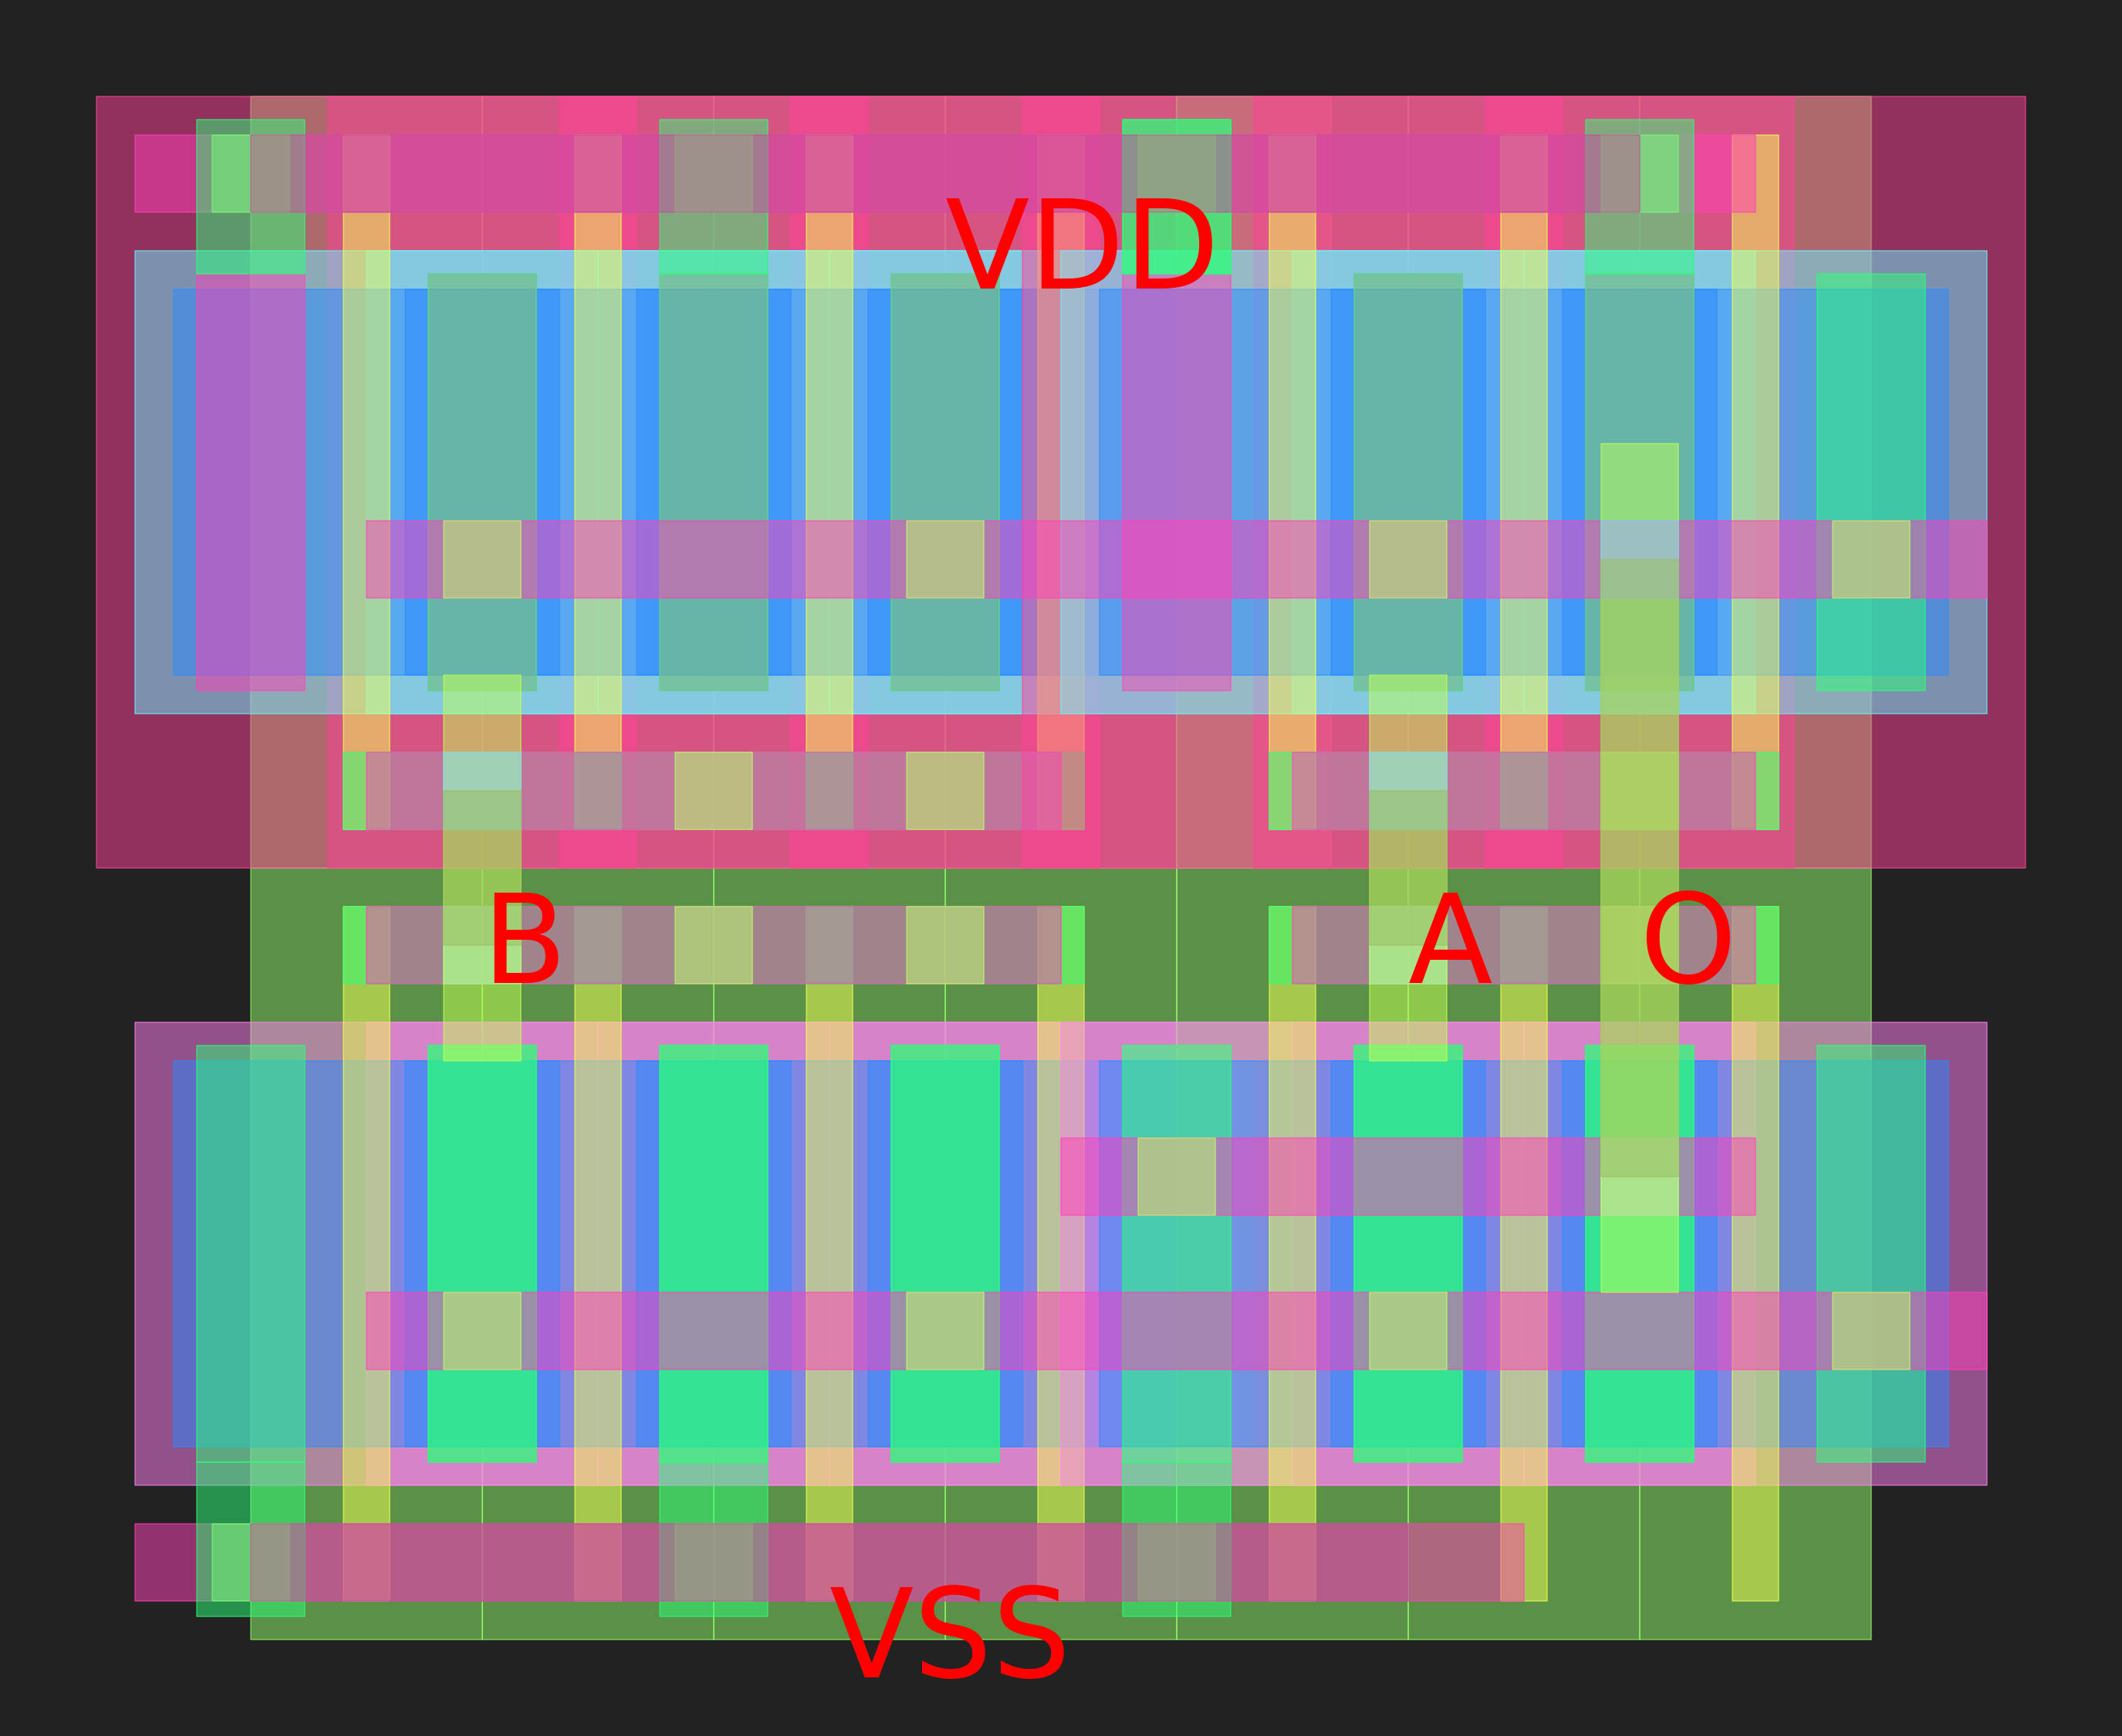

In [ ]:
from IPython.display import Image
Image('laygo2_test_nand2.png')